In [ ]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpy as np

from __future__ import annotations
import numpy as np
from skimage.restoration import unwrap_phase
from temgym_core.gaussian import map_reduce
from temgym_core.components import Detector
from temgym_core.utils import fibonacci_spiral, fibonacci_spiral_square
from temgym_core.ray import Ray
from temgym_core.gaussian import GaussianRayBeta

import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)
import jax_dataclasses as jdc

In [3]:
# ---------- pure-JAX interpolation ----------

def _clamp(v, lo, hi):
    return jnp.clip(v, lo, hi)


def _get_texels(img, ys, xs):
    """Gather tensor values with broadcasted indices; img shape (H,W)."""
    H, W = img.shape
    ys = _clamp(ys, 0, H - 1)
    xs = _clamp(xs, 0, W - 1)
    return img[ys, xs]


def _bilinear_sample(img, y, x):
    """Bilinear sample of 2D image at fractional (y,x). y,x can be arrays."""
    H, W = img.shape
    y0 = jnp.floor(y).astype(jnp.int32)
    x0 = jnp.floor(x).astype(jnp.int32)
    y1 = jnp.minimum(y0 + 1, H - 1)
    x1 = jnp.minimum(x0 + 1, W - 1)

    wy = y - y0.astype(y.dtype)
    wx = x - x0.astype(x.dtype)

    v00 = _get_texels(img, y0, x0)
    v01 = _get_texels(img, y0, x1)
    v10 = _get_texels(img, y1, x0)
    v11 = _get_texels(img, y1, x1)

    v0 = v00 * (1 - wx) + v01 * wx
    v1 = v10 * (1 - wx) + v11 * wx
    return v0 * (1 - wy) + v1 * wy


def _keys_cubic(t, a=-0.5):
    """Keys cubic convolution kernel (Catmull-Rom for a=-0.5). t in [0,1]."""
    t = jnp.asarray(t)
    t2 = t * t
    t3 = t2 * t
    c0 = (-a) * t + (2 - a) * t2 + (a - 2) * t3
    c1 = 1 + (a - 3) * t2 + (2 - a) * t3
    c2 = a * t + (3 - 2 * a) * t2 + (a - 2) * t3
    c3 = (-a) * t2 + (1 - a) * t3
    # But the above assumes basis at offsets [ -1, 0, 1, 2 ]. We'll assemble weights directly in sampler.
    return c0, c1, c2, c3


def _cubic_weights(f, a=-0.5):
    """
    Return weights for fractional offset f in [0,1) for samples at offsets
    -1, 0, 1, 2 using Keys cubic with parameter a.
    """
    f2 = f * f
    f3 = f2 * f
    w_m1 = -a * f + 2 * a * f2 - a * f3
    w_0  = 1 + (a - 3) * f2 + (2 - a) * f3
    w_p1 = a * f + (3 - 2 * a) * f2 + (a - 2) * f3
    w_p2 = -a * f2 + a * f3
    return w_m1, w_0, w_p1, w_p2


def _bicubic_sample(img, y, x, a=-0.5):
    """Bicubic sample using separable Keys cubic (Catmull-Rom a=-0.5)."""
    H, W = img.shape
    y0f = jnp.floor(y)
    x0f = jnp.floor(x)
    fy = (y - y0f).astype(jnp.float64)
    fx = (x - x0f).astype(jnp.float64)

    y0 = y0f.astype(jnp.int32)
    x0 = x0f.astype(jnp.int32)

    # Neighbor rows and cols with clamping
    y_m1 = _clamp(y0 - 1, 0, H - 1)
    y_p0 = _clamp(y0 + 0, 0, H - 1)
    y_p1 = _clamp(y0 + 1, 0, H - 1)
    y_p2 = _clamp(y0 + 2, 0, H - 1)

    x_m1 = _clamp(x0 - 1, 0, W - 1)
    x_p0 = _clamp(x0 + 0, 0, W - 1)
    x_p1 = _clamp(x0 + 1, 0, W - 1)
    x_p2 = _clamp(x0 + 2, 0, W - 1)

    # Weights
    wy_m1, wy_0, wy_1, wy_2 = _cubic_weights(fy, a)
    wx_m1, wx_0, wx_1, wx_2 = _cubic_weights(fx, a)

    # Gather 4x4 neighborhood and apply separable weights
    def row_interp(y_idx):
        v_m1 = _get_texels(img, y_idx, x_m1)
        v_0  = _get_texels(img, y_idx, x_p0)
        v_1  = _get_texels(img, y_idx, x_p1)
        v_2  = _get_texels(img, y_idx, x_p2)
        return v_m1 * wx_m1 + v_0 * wx_0 + v_1 * wx_1 + v_2 * wx_2

    r_m1 = row_interp(y_m1)
    r_0  = row_interp(y_p0)
    r_1  = row_interp(y_p1)
    r_2  = row_interp(y_p2)

    return r_m1 * wy_m1 + r_0 * wy_0 + r_1 * wy_1 + r_2 * wy_2


In [4]:
def _beam_field(r_m, C, eta, Q_inv, phase_offset, k, r2):
    delta = r2 - r_m
    lin  = jnp.sum(delta * eta, axis=-1)                # (P,)
    quad = jnp.sum((delta @ Q_inv) * delta, axis=-1)    # (P,)

    k = jnp.asarray(k).reshape(())                      # scalar
    phase = k * (lin + 0.5 * quad)                     # (P,) complex

    # separate to keep amplitude stable
    a = jnp.real(phase)   # pure phase (radians)
    b = jnp.imag(phase)   # local log-amplitude Taylor

    b = jnp.clip(b, a_min=-700.0, a_max=0.0)

    amp0 = C * jnp.exp(1j * phase_offset)              # scalar
    return amp0 * jnp.exp(b) * jnp.exp(-1j * a)        # (P,)

def _beam_field_outer(xs, r2):
    r_m_i, C_i, eta_i, Q_i, phase_offset_i, k_i = xs
    return _beam_field(r_m_i, C_i, eta_i, Q_i, phase_offset_i, k_i, r2)

def evaluate_gaussian_packets_jax_scan(gaussian_ray, grid, *, batch_size: int | None = 128):
    # Pull arrays from the (possibly vectorized) Gaussian ray
    r_m = gaussian_ray.r_xy
    C = gaussian_ray.C
    eta = gaussian_ray.eta
    Q_inv = gaussian_ray.Q_inv
    k = gaussian_ray.k0
    path = gaussian_ray.pathlength
    phase_offset = k * path

    r2 = grid.coords
    P  = r2.shape[0]
    init = jnp.zeros((P,), dtype=jnp.complex128)

    def f_pack(xs):
        return _beam_field_outer(xs, r2)

    xs = (r_m, C, eta, Q_inv, phase_offset, k)
    out = map_reduce(f_pack, jnp.add, init, xs, batch_size=batch_size)
    return out.reshape(grid.shape)


evaluate_gaussian_packets_jax_scan = jax.jit(
    evaluate_gaussian_packets_jax_scan, static_argnames=["batch_size", "grid"]
)

In [5]:
def _as_batch(r):
    r = r if r.ndim == 2 else r[None, ...]         # (2,) -> (1,2)
    return r

def _split_real_imag(component, rr):
    z = component.complex_action(rr)
    return jnp.stack([jnp.real(z), jnp.imag(z)])

def grad_opl(component, xy_batch):
    # J shape: (B, 2_out=[Reψ, Imψ], 2_in=[x,y])
    J = jax.vmap(jax.jacfwd(_split_real_imag, argnums=1), in_axes=(None, 0))(component, xy_batch)
    g_phi  = J[:, 0, :]            # ∇φ
    g_imag = J[:, 1, :]            # ∇(Im ψ) = ∇(-ℓ) = -∇ℓ
    return g_phi + 1j * g_imag     # == ∇φ - i∇ℓ   (correct)

def hess_opl(component, xy_batch):
    # H shape: (B, 2_out=[Reψ, Imψ], 2, 2)
    H = jax.vmap(
        jax.jacfwd(jax.jacrev(_split_real_imag, argnums=1), argnums=1),
        in_axes=(None, 0)
    )(component, xy_batch)
    H_phi  = H[:, 0, :, :]         # Hφ
    H_imag = H[:, 1, :, :]         # H(Im ψ) = H(-ℓ) = -Hℓ
    Hc = H_phi + 1j * H_imag       # == Hφ - iHℓ   (correct)
    return 0.5 * (Hc + jnp.swapaxes(Hc, -1, -2))  # symmetrize


def apply_thin_element_from_complex_opl(gp: GaussianRayBeta, opl, grad_opl, Hess_opl):
    """
    opl      : (B,)   complex = φ - iℓ
    grad_opl : (B,2)  complex = ∇φ - i∇ℓ
    Hess_opl : (B,2,2) complex = Hφ - iHℓ
    """
    k = gp.k0
    # Expand k to match shapes safely (works for scalar or vector k)
    k_vec = k if jnp.ndim(k) == 0 else k[:, None]         # (,) or (B,1)
    k_mat = k if jnp.ndim(k) == 0 else k[:, None, None]   # (,) or (B,1,1)

    phi0 = jnp.real(opl)         # (B,)
    im0  = jnp.imag(opl)         # (B,)  == -ℓ
    C_out = gp.C * jnp.exp(-im0) * jnp.exp(1j * k * phi0)

    g_phi = jnp.real(grad_opl)   # (B,2)
    g_im  = jnp.imag(grad_opl)   # (B,2) == -∇ℓ
    H_phi = jnp.real(Hess_opl)   # (B,2,2)
    H_im  = jnp.imag(Hess_opl)   # (B,2,2) == -Hℓ

    # η' = η - ∇φ - i ∇ℓ / k  (since g_im = -∇ℓ)
    eta_out  = gp.eta  - g_phi - 1j * (g_im / k_vec)
    # Qinv' = Qinv - Hφ - i Hℓ / k
    Qinv_out = gp.Q_inv - H_phi - 1j * (H_im / k_mat)

    dxy_in  = gp.d_xy
    dxy_out = dxy_in - g_phi

    return gp.derive(dx=dxy_out[..., 0], dy=dxy_out[..., 1],
                     Q_inv=Qinv_out, eta=eta_out, C=C_out)


@jdc.pytree_dataclass
class Component:
    z: float

    def complex_action(self, xy: jnp.ndarray) -> complex:
        """Return φ(x,y) - i ℓ(x,y). Default: no effect."""
        return jnp.zeros((), dtype=jnp.complex128)


    def __call__(self, ray):
        # (B,2) positions
        r_xy = ray.r_xy
        r_xy = _as_batch(r_xy)

        # φ - iℓ at points (for C update)
        opl = jax.vmap(self.complex_action)(r_xy)
        # Jac and Hessian
        g_opl = grad_opl(self, r_xy)

        if isinstance(ray, GaussianRayBeta):
            H_opl = hess_opl(self, r_xy)
            out = apply_thin_element_from_complex_opl(ray, opl, g_opl, H_opl)
            return out.derive(z=self.z)

        # Geometric ray: only phase gradient affects slopes
        dxy = ray.d_xy - jnp.real(g_opl)
        return ray.derive(dx=dxy[...,0], dy=dxy[...,1], z=self.z)

    
@jdc.pytree_dataclass
class Lens(Component):
    focal_length: float

    def complex_action(self, xy):
        x, y = xy[..., 0], xy[..., 1]
        rho2 = x*x + y*y
        phase = -0.5 * rho2 / self.focal_length
        log_amplitude = 0.0
        return phase - 1j * log_amplitude


@jdc.pytree_dataclass
class AberratedLens(Component):
    focal_length: float
    C_sph: float = 0.0
    C_coma_x: float = 0.0
    C_coma_y: float = 0.0

    def complex_action(self, xy):
        x, y = xy[..., 0], xy[..., 1]
        rho2 = x*x + y*y

        # Aberration expansion
        phase = (
            -0.5 * rho2 / self.focal_length
            + self.C_sph * (rho2**2)
            + self.C_coma_x * (x**3 + x*y**2)
            + self.C_coma_y * (y**3 + y*x**2)
        )
        log_amplitude = 0.0
        return phase - 1j * log_amplitude

from jax.nn import softplus  # already have sigmoid imported

@jdc.pytree_dataclass
class SigmoidAperture(Component):
    radius: float
    sharpness: float = 50.0  # start sane; you can dial this up later
    eps: float = 1e-12

    def complex_action(self, xy):
        x, y = xy[..., 0], xy[..., 1]
        # well-behaved radius (grad/Hess defined at the origin)
        r = jnp.sqrt(x * x + y * y + self.eps)

        # We want log σ(α) with α = -s (r - R). Use stable identity:
        # logσ(α) = -softplus(-α)  ->  -softplus(s*(r - R))
        t = self.sharpness * (r - self.radius)
        logA = -softplus(t)              # == log(sigmoid(-s*(r-R))) stably

        # Pure amplitude mask: ψ = φ - iℓ, here φ=0, ℓ = logA (≤ 0)
        return -1j * logA

@jdc.pytree_dataclass
class FreeSpaceParaxial(Component):
    distance: float  # L

    # Not a thin element; keep complex_action a no-op so base class won't use it.
    def complex_action(self, xy):
        return jnp.array(0.0, dtype=jnp.complex128)

    def __call__(self, ray):
        L = self.distance

        # --- advance center positions and z ---
        x_new = ray.x + ray.dx * L
        y_new = ray.y + ray.dy * L
        z_new = ray.z + L

        # Paraxial OPL increment (use L only if you prefer)
        path_inc = L * (1.0 + 0.5 * (ray.dx**2 + ray.dy**2))
        path_new = ray.pathlength + path_inc

        # Geometric ray path
        if not hasattr(ray, "Q_inv"):
            return ray.derive(x=x_new, y=y_new, z=z_new, pathlength=path_new)

        # Gaussian ray path (ABCD with A=I, B=L I, C=0, D=I)
        Qinv = ray.Q_inv
        I2 = jnp.eye(2, dtype=jnp.complex128)
        M = I2 + L * Qinv
        M_inv = jnp.linalg.inv(M)
        Qinv_new = Qinv @ M_inv
        eta_new = (jnp.swapaxes(M_inv, -1, -2) @ ray.eta[..., None])[..., 0]
        C_new = ray.C / jnp.sqrt(jnp.linalg.det(M))

        return ray.derive(
            x=x_new, y=y_new, z=z_new, pathlength=path_new,
            Q_inv=Qinv_new, eta=eta_new, C=C_new
        )

def run_to_end(ray, components):
    r = ray
    for comp in components:
        r = comp(r)
    return r


Single Beam Case

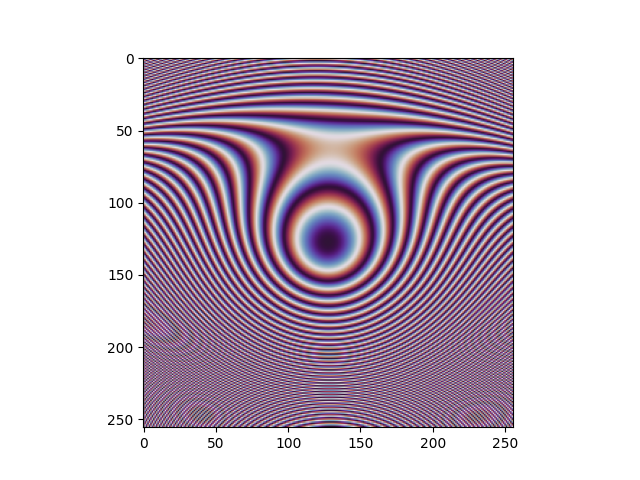

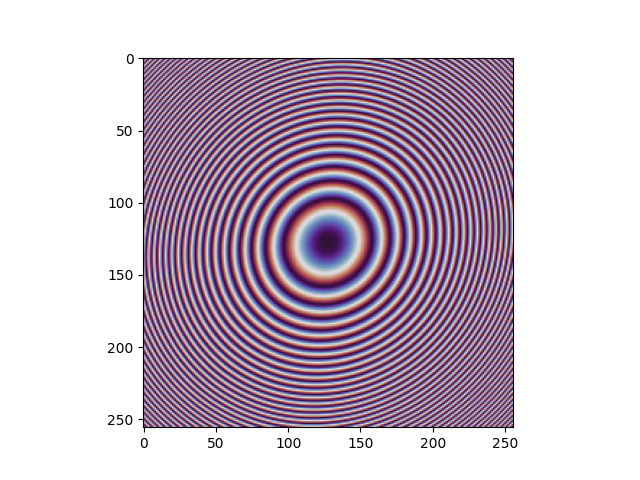

In [6]:
w0  = 4
f   = 100.0
C_sph   = 1.0e-6
C_coma_x = 1e-5
C_coma_y = 2e-4

wavelength = 0.25
num_rays = 1
rx, ry = 2, 0.0
lam = jnp.ones(num_rays)*wavelength
k0  = 2*jnp.pi/lam
C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
eta = jnp.full((num_rays,2), 0.0+0.0j)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)

ray0 = GaussianRayBeta(x=rx, 
                       y=ry, 
                       dx=0.0, 
                       dy=0.0, 
                       z=0.0, 
                       pathlength=0.0,
                       Q_inv=Qinv0, 
                       eta=eta, 
                       C=C0, 
                       k0=k0)
ray0=ray0.to_vector()

lens = AberratedLens(z=0.0, focal_length=f, C_sph=C_sph, C_coma_x=C_coma_x, C_coma_y=C_coma_y)
gp1  = lens.__call__(ray0)

W = 60
Nx = Ny = 256
dx = W/Nx
dy = W/Ny
grid = Detector(z=lens.z + 0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]

rxy_img = jnp.stack([jnp.asarray(X), jnp.asarray(Y)], axis=-1)  # (Ny,Nx,2)
phi_exact = np.exp(1j * k0 * jnp.real(lens.complex_action(rxy_img)))                                   # (Ny,Nx)

# Single beam
x0 = float(np.ravel(rx)[0]); 
y0 = float(np.ravel(ry)[0])
E_in = jnp.exp(-(((X - x0)**2 + (Y - y0)**2) / w0**2))      # (Ny,Nx)
E_exact =  phi_exact * E_in           # (Ny,Nx)

plt.figure()
plt.imshow(np.angle(E_exact), cmap='twilight')
# Local-Gaussian approximation after the component update
# Evaluate at (X-x0, Y-y0) so the Gaussian is centered at (x0, y0)
# lin = gp1.theta[0]*(X - x0) + gp1.theta[1]*(Y - y0)
# Q = gp1.Q_inv
# quad = (Q[0,0]*((X - x0)**2) + (Q[0,1]+Q[1,0])*(0.5*(X - x0)*(Y - y0)) + Q[1,1]*((Y - y0)**2))
# E_local = gp1.C * np.exp(-1j*gp1.k0*(lin + 0.5*quad))

E_local = evaluate_gaussian_packets_jax_scan(gp1, grid, batch_size=1)

plt.figure()
plt.imshow(np.angle(E_local), cmap='twilight')

In [7]:
amp_exact = np.abs(E_exact); amp_exact /= amp_exact.max()

phase_exact = np.angle(E_exact)
phase_local = np.angle(E_local)
phase_diff = np.angle(np.exp(1j*(np.abs(phase_exact) - np.abs(phase_local))))
phase_exact_unwrapped = unwrap_phase(phase_exact)
phase_local_unwrapped = unwrap_phase(phase_local)

# Convert unwrapped phases to optical path length (OPL)
opl_exact_unwrapped = phase_exact_unwrapped / gp1.k0
opl_local_unwrapped = phase_local_unwrapped / gp1.k0

# Pick a reference point near the beam center (x0,y0) and align both OPLs there.
# This removes the arbitrary constant offset between the two OPL maps.
ix0 = np.argmin(np.abs(x - rx))
iy0 = np.argmin(np.abs(y - ry))

ref_exact = opl_exact_unwrapped[iy0, ix0]
ref_local = opl_local_unwrapped[iy0, ix0]

opl_exact_unwrapped = opl_exact_unwrapped - ref_exact
opl_local_unwrapped = opl_local_unwrapped - ref_local

# Keep wrapped/unwrapped phase variables consistent (if needed downstream)
phase_exact_unwrapped = opl_exact_unwrapped * gp1.k0
phase_local_unwrapped  = opl_local_unwrapped * gp1.k0

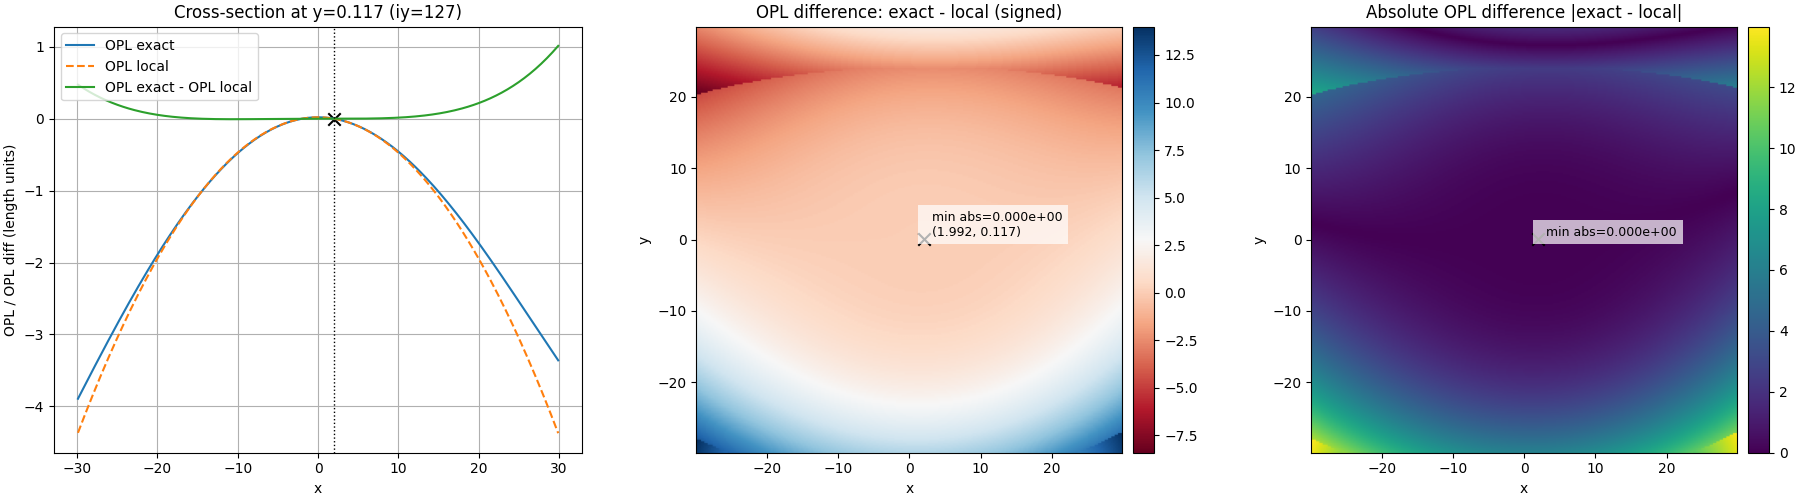

In [8]:
extent = [x.min(), x.max(), y.min(), y.max()]

# compute difference and global minimum (use existing variables if present)
diff_opl = opl_exact_unwrapped - opl_local_unwrapped
diff_abs = np.abs(diff_opl)
iy_min, ix_min = np.unravel_index(np.argmin(diff_abs), diff_abs.shape)
x_min = float(x[ix_min]); y_min = float(y[iy_min])
min_val = float(diff_abs[iy_min, ix_min])

iy = int(np.argmin(np.abs(y - ry)))  # cross-section row near ry
opl_diff_cross = diff_opl[iy, :]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# 1) Cross-section at y ~ ry (moved into first panel)
ax = axes[0]
ax.plot(x, opl_exact_unwrapped[iy, :], label='OPL exact', color='C0')
ax.plot(x, opl_local_unwrapped[iy, :], label='OPL local', linestyle='--', color='C1')
ax.plot(x, opl_diff_cross, label='OPL exact - OPL local', color='C2')
# mark global-min (vertical line + marker at cross-section value)
ax.axvline(x=x_min, color='k', linestyle=':', linewidth=1)
val_at_xmin = float(np.interp(x_min, x, opl_diff_cross))
ax.scatter([x_min], [val_at_xmin], c='k', marker='x', s=80)
ax.set_title(f'Cross-section at y={y[iy]:.3f} (iy={iy})')
ax.set_xlabel('x'); ax.set_ylabel('OPL / OPL diff (length units)')
ax.grid(True)
ax.legend(loc='upper left')

# 2) Signed OPL difference (exact - local)
ax = axes[1]
cmap = 'RdBu'
im2 = ax.imshow(diff_opl, origin='lower', extent=extent, aspect='equal', cmap=cmap)
ax.set_title('OPL difference: exact - local (signed)')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.scatter(x_min, y_min, c='k', marker='x', s=80)
ax.text(x_min, y_min, f'  min abs={min_val:.3e}\n  ({x_min:.3f}, {y_min:.3f})',
    color='k', fontsize=9, verticalalignment='bottom', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.02)

# 3) Absolute OPL difference (magnitude) for clarity
ax = axes[2]
im3 = ax.imshow(diff_abs, origin='lower', extent=extent, aspect='equal', cmap='viridis')
ax.set_title('Absolute OPL difference |exact - local|')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.scatter(x_min, y_min, c='k', marker='x', s=80)
ax.text(x_min, y_min, f'  min abs={min_val:.3e}', color='k', fontsize=9,
    verticalalignment='bottom', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.02)

plt.show()


n_beams case

In [9]:
w0  = 0.25
f   = 100.0
C_sph   = 1.0e-6
C_coma_x = 1e-5
C_coma_y = 2e-4
W = 60
wavelength = 0.25

radius = W / 2 * np.sqrt(2)# add a small margin to ensure full coverage
num_rays = 50000
rx, ry = fibonacci_spiral(num_rays, radius=radius)

mask = (np.abs(rx) <= W/2  + W / 5 ) & (np.abs(ry) <= W/2 + W / 5  )
rx = rx[mask]
ry = ry[mask]
num_rays = len(rx)

lam = jnp.ones(num_rays)*wavelength
k0  = 2*jnp.pi/lam
C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
eta = jnp.full((num_rays,2), 0.0+0.0j)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)

ray0 = GaussianRayBeta(x=rx, 
                       y=ry, 
                       dx=0.0, 
                       dy=0.0, 
                       z=0.0, 
                       pathlength=0.0,
                       Q_inv=Qinv0, 
                       eta=eta, 
                       C=C0, 
                       k0=k0)
ray0=ray0.to_vector()

lens = AberratedLens(z=0.0, focal_length=f, C_sph=C_sph, C_coma_x=C_coma_x, C_coma_y=C_coma_y)
gp1  = lens.__call__(ray0)   # <-- uses the component path


Nx = Ny = 256
dx = W/Nx
dy = W/Ny
grid = Detector(z=lens.z + 0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]

In [10]:
E_local = evaluate_gaussian_packets_jax_scan(gp1, grid, batch_size=100)

In [11]:
# %%timeit
# E_local = evaluate_gaussian_packets_jax_scan(gp1, grid)

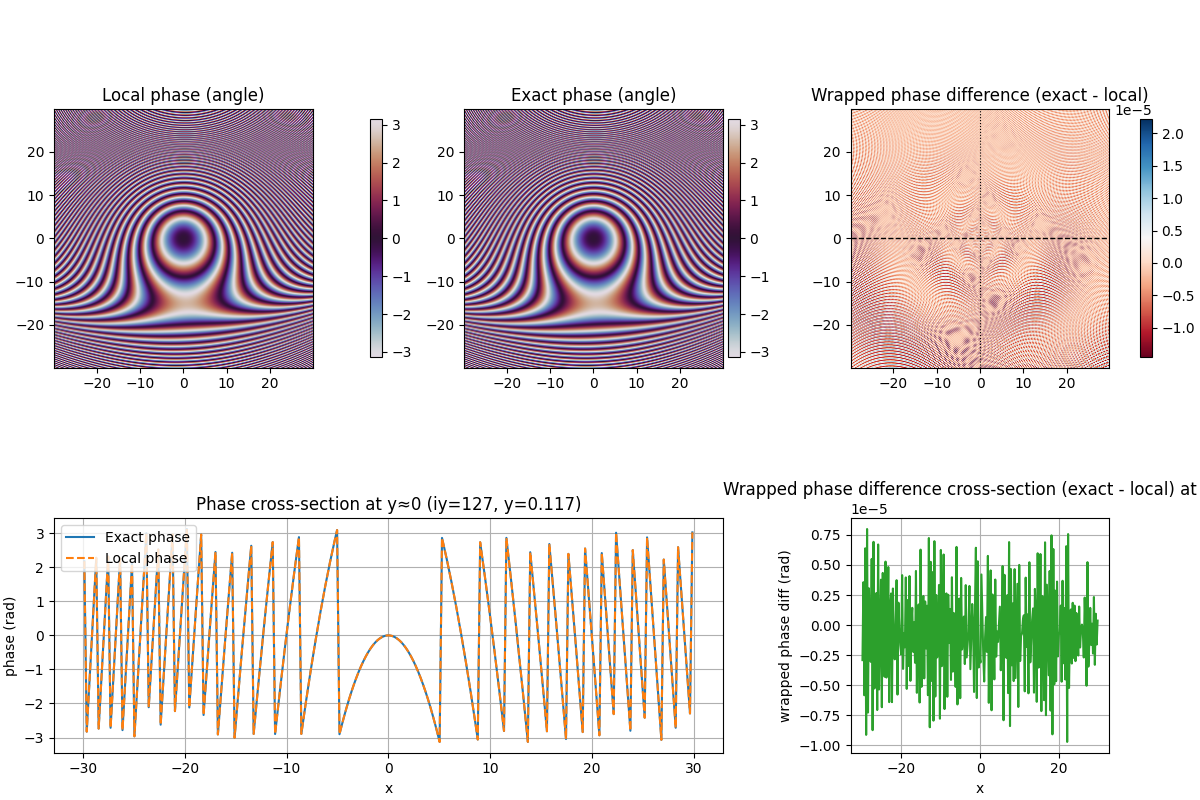

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.5], width_ratios=[1, 1, 1])

# Top row: three main plots in a row
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Bottom row: cross-sections (left spans two cols, right in the last col)
ax4 = fig.add_subplot(gs[1, :2])
ax5 = fig.add_subplot(gs[1, 2])

# Ensure numpy arrays for matplotlib
ang_local = np.angle(np.asarray(E_local))
ang_exact = np.angle(np.asarray(phi_exact))
x_np = np.asarray(x)
y_np = np.asarray(y)

# 1) local phase
im1 = ax1.imshow(ang_local, origin='lower', extent=extent, aspect='equal', cmap='twilight')
ax1.set_title('Local phase (angle)')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)

# 2) exact phase
im2 = ax2.imshow(ang_exact, origin='lower', extent=extent, aspect='equal', cmap='twilight')
ax2.set_title('Exact phase (angle)')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)

# 3) Wrapped phase difference (large view)
diff = np.angle(np.exp(1j * (ang_exact - ang_local)))
im3 = ax3.imshow(diff, origin='lower', extent=extent, aspect='equal', cmap='RdBu')
ax3.set_title('Wrapped phase difference (exact - local)')
ax3.axhline(0.0, color='k', linestyle='--', linewidth=1)
ax3.axvline(0.0, color='k', linestyle=':', linewidth=0.8)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.02)

# Find row index nearest y=0 for cross-section
iy0 = int(np.argmin(np.abs(y_np - 0.0)))

# Cross-sections (y ~ 0)
ang_local_cs = ang_local[iy0, :]
ang_exact_cs = ang_exact[iy0, :]
diff_cs = diff[iy0, :]

# 4) Phase cross-section at y=0 (spanning left two columns)
ax4.plot(x_np, ang_exact_cs, label='Exact phase', color='C0')
ax4.plot(x_np, ang_local_cs, label='Local phase', linestyle='--', color='C1')
ax4.set_title(f'Phase cross-section at y≈0 (iy={iy0}, y={y_np[iy0]:.3f})')
ax4.set_xlabel('x'); ax4.set_ylabel('phase (rad)')
ax4.grid(True); ax4.legend(loc='upper left')

# 5) Wrapped phase-difference cross-section at y=0 (right column)
ax5.plot(x_np, diff_cs, color='C2')
ax5.set_title('Wrapped phase difference cross-section (exact - local) at y≈0')
ax5.set_xlabel('x'); ax5.set_ylabel('wrapped phase diff (rad)')
ax5.grid(True)


plt.show()

In [13]:
aperture = SigmoidAperture(radius=W/4, sharpness=10000, z=0.0)
free_space = FreeSpaceParaxial(distance=200.0, z=aperture.z)
components = [aperture, free_space]


ray0 = ray0.derive(x=ray0.x, y=ray0.y)
gp2 = run_to_end(ray0, components)

In [14]:
E_input_after_aperture = evaluate_gaussian_packets_jax_scan(aperture(ray0), grid, batch_size=2000)
E_local = evaluate_gaussian_packets_jax_scan(gp2, grid, batch_size=2000)

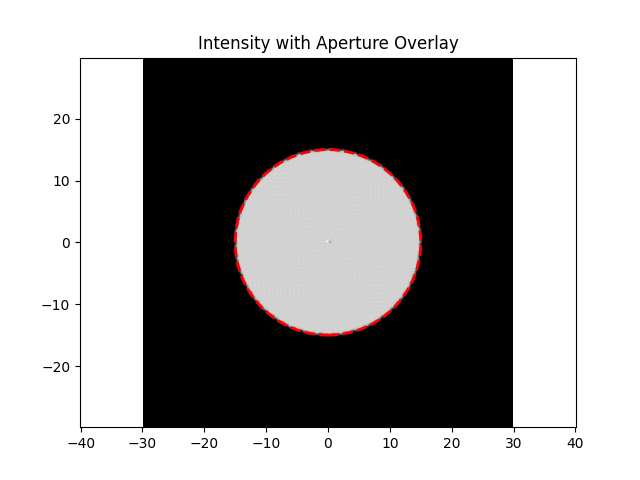

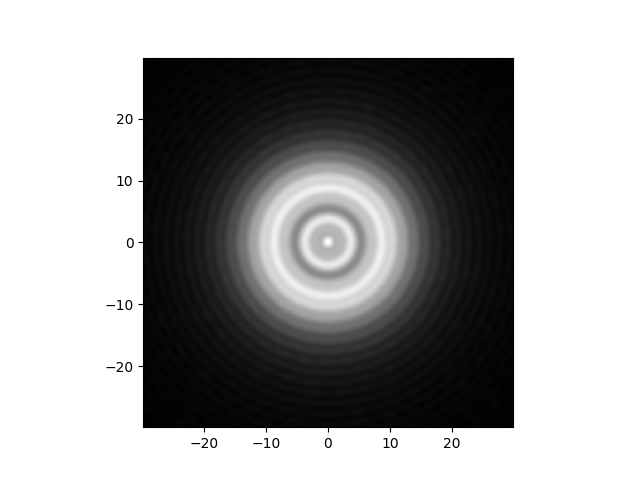

In [15]:

plt.figure()
plt.title('Intensity with Aperture Overlay')
plt.axis('equal')
circle = plt.Circle((0, 0), aperture.radius, color='red', fill=False, linestyle='--', linewidth=2)
plt.gca().add_artist(circle)
plt.imshow(np.abs(E_input_after_aperture), cmap='gray', extent=extent)

# Plot the aperture radius on top of the intensity image
plt.figure()
plt.imshow(np.abs(E_local), cmap='gray', extent=extent)




In [16]:
import numpy as np
import jax.numpy as jnp
import jax_dataclasses as jdc

from ase import Atoms
import abtem

# ---------- relativistic constants ----------
def electron_wavelength_angstrom(accel_kV: float) -> float:
    h  = 6.62607015e-34
    m0 = 9.1093837015e-31
    c  = 299792458.0
    e  = 1.602176634e-19
    V  = accel_kV * 1e3
    p  = np.sqrt(2*m0*e*V*(1.0 + (e*V)/(2.0*m0*c*c)))
    return (h/p) * 1e10  # Å


def interaction_constant_sigma(accel_kV: float) -> float:
    h  = 6.62607015e-34
    m0 = 9.1093837015e-31
    c  = 299792458.0
    e  = 1.602176634e-19
    V   = accel_kV * 1e3
    gamma = 1.0 + (e*V)/(m0*c*c)
    m_rel = gamma * m0
    lam_m = electron_wavelength_angstrom(accel_kV) * 1e-10
    sigma_SI = 2.0*np.pi * m_rel * e * lam_m / (h*h)   # rad / V / m
    return sigma_SI * 1e-10                            # rad / (V·Å)


# ---------- abTEM helper ----------
def abtem_single_atom_projected_potential(
    symbol="Si", box_A=(20.,20.,20.), sampling_A=0.05,
    parametrization="lobato", projection="infinite"
):
    """
    Build a single-atom projected potential using abTEM.

    Returns
    -------
    V_proj : np.ndarray (ny, nx), units V·Å
    sx, sy : float, pixel sizes in Å/px (x then y)
    x0, y0 : float, physical coordinates (Å) that map pixel (0,0) -> (x0,y0)
              We set x0 = -Lx/2 and y0 = -Ly/2 so that physical (0,0)
              corresponds to the geometric center of the image. This makes
              a single atom placed at box center sit at (x,y)=(0,0).
    """
    Lx, Ly, Lz = map(float, box_A)
    atoms = Atoms(symbols=symbol, positions=[[Lx/2, Ly/2, Lz/2]],
                  cell=[Lx, Ly, Lz], pbc=False)
    pot = abtem.Potential(
        atoms, sampling=sampling_A, parametrization=parametrization,
        slice_thickness=1.0, projection=projection, periodic=False, box=(Lx,Ly,Lz)
    )
    proj = pot.project().compute()
    V_proj = np.asarray(proj.array)          # shape (ny, nx), units V·Å
    sy, sx = proj.sampling                   # Å/px (y, x)

    # Choose origin so that (x,y)=(0,0) is at the image center
    x0 = -Lx/2.0
    y0 = -Ly/2.0
    return V_proj, sx, sy, x0, y0


@jdc.pytree_dataclass
class PotentialPhase(Component):
    """
    Thin phase element using pure-JAX interpolation of a projected potential
    V(x,y) (units V·Å).

    complex_action(x,y) = sigma * V(x,y)  (pure phase; ℓ = 0)

    Interpolation
    -------------
    - order <= 1 -> bilinear
    - order >= 3 -> bicubic (Keys, a=-0.5, Catmull-Rom)

    Notes
    -----
    - Coordinates xy are in Å, measured from image center (0,0).
    - Pixel mapping: xp=(x-x0)/sx, yp=(y-y0)/sy (pixel indices).
    - Boundary: clamped (nearest) to keep gradients stable.
    - Fully JIT- and autodiff-compatible; avoids ndimage limitations.
    """
    V: jnp.ndarray        # (ny, nx), float64, in V·Å
    sx: float             # Å/px (x-direction)
    sy: float             # Å/px (y-direction)
    x0: float             # physical coord of pixel (0,0), x
    y0: float             # physical coord of pixel (0,0), y
    sigma: float          # rad / (V·Å)
    order: int = 3        # 1=bilinear, 3=bicubic

    def _coords_px(self, xy):
        # xy: (..., 2) in Å  -> pixel coordinates (y,x)
        x = xy[..., 0]; y = xy[..., 1]
        xp = (x - self.x0) / self.sx
        yp = (y - self.y0) / self.sy
        return yp, xp

    def complex_action(self, xy):
        yp, xp = self._coords_px(xy)
        if int(self.order) <= 1:
            Vxy = _bilinear_sample(self.V, yp, xp)
        else:
            Vxy = _bicubic_sample(self.V, yp, xp, a=-0.5)
        phase = self.sigma * Vxy  # radians
        return phase - 1j * 0.0

# ---------- one-shot builder ----------
def make_spline_potential_component_from_abtem(
    symbol="Si", accel_kV=200.0, box_A=(20.,20.,20.), sampling_A=0.05,
    parametrization="lobato", projection="infinite", z=0.0,
    order=3
):
    V_proj, sx, sy, x0, y0 = abtem_single_atom_projected_potential(
        symbol=symbol, box_A=box_A, sampling_A=sampling_A,
        parametrization=parametrization, projection=projection
    )
    sigma = interaction_constant_sigma(accel_kV)
    comp = PotentialPhase(
        z=z,
        V=jnp.asarray(V_proj, dtype=jnp.float64),
        sx=float(sx), sy=float(sy), x0=float(x0), y0=float(y0),
        sigma=float(sigma), order=int(order)
    )
    meta = dict(symbol=symbol, accel_kV=accel_kV, sampling=(sx,sy),
                box_A=box_A, parametrization=parametrization,
                projection=projection, sigma=sigma)
    return comp, meta

In [45]:
# Build spline-based thin element from abTEM
accel_kV = 200.00
comp, meta = make_spline_potential_component_from_abtem(
    symbol="Si", accel_kV=accel_kV, sampling_A=0.1, box_A=(20,20,20)
)

w0 = 0.005
wavelength = electron_wavelength_angstrom(accel_kV)
num_rays = 500000
rx, ry = fibonacci_spiral(num_rays, radius=5.0)
lam = jnp.ones(num_rays)*wavelength
k0  = 2*jnp.pi/lam
C0 = jnp.ones(num_rays)*(1.0 + 0.0j)
eta = jnp.full((num_rays,2), 0.0+0.0j)
scale = -1j * (2.0 / (k0 * w0**2))
Qinv0 = scale[..., None, None] * jnp.eye(2, dtype=jnp.complex128)

ray0 = GaussianRayBeta(x=rx, 
                       y=ry, 
                       dx=0.0, 
                       dy=0.0, 
                       z=0.0, 
                       pathlength=0.0,
                       Q_inv=Qinv0, 
                       eta=eta, 
                       C=C0, 
                       k0=k0)
free_space = FreeSpaceParaxial(distance=50, z=comp.z)
components = [comp, free_space]
ray_out = run_to_end(ray0, components)

[                                        ] | 0% Completed | 348.65 us

[########################################] | 100% Completed | 105.13 ms


In [46]:
E_atom = evaluate_gaussian_packets_jax_scan(ray_out, grid, batch_size=1000)

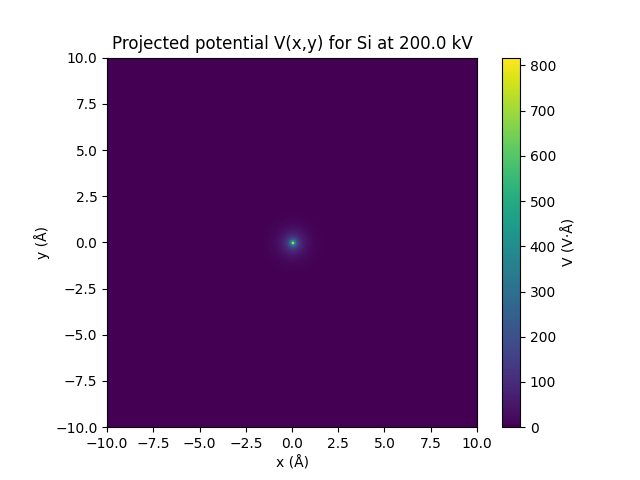

In [54]:
potential = np.asarray(comp.V)
plt.figure()
plt.imshow(potential, cmap='viridis', extent=[comp.x0, comp.x0 + potential.shape[1]*comp.sx,
                                              comp.y0, comp.y0 + potential.shape[0]*comp.sy])
plt.title(f"Projected potential V(x,y) for {meta['symbol']} at {meta['accel_kV']} kV")
plt.xlabel('x (Å)'); plt.ylabel('y (Å)')
plt.colorbar(label='V (V·Å)')
plt.show()

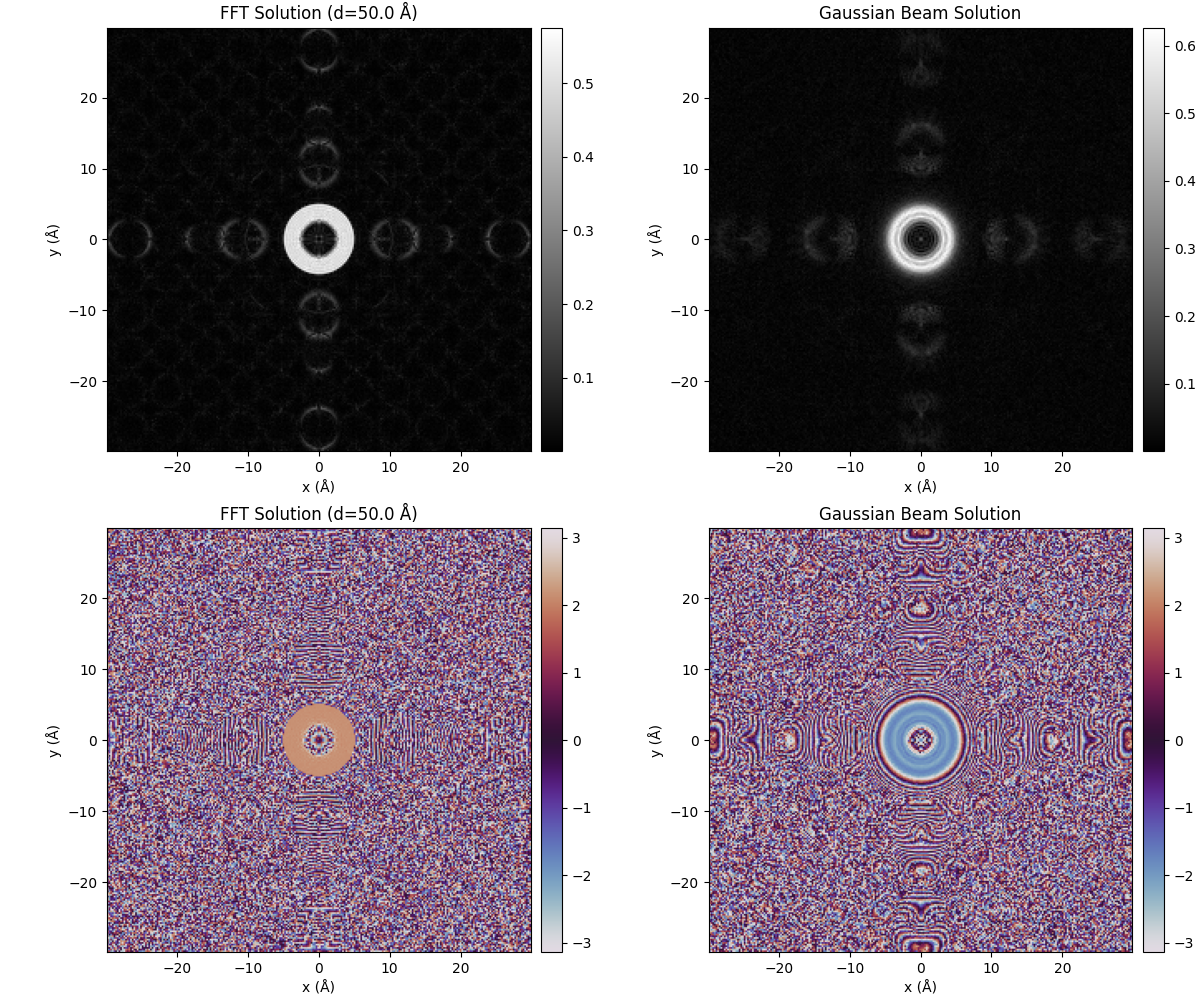

In [51]:
# propagate the exit wave E_atom by distance d (units: Å)
d = 50.0  # propagation distance in Å (change as needed)

# ensure numpy arrays
E0 = np.asarray(E_atom)
Ny, Nx = E0.shape

# pixel sizes from existing grid (units should match wavelength: Å/px)
dx, dy = grid.pixel_size

# spatial frequency axes (cycles / Å)
fx = np.fft.fftfreq(Nx, dx)
fy = np.fft.fftfreq(Ny, dy)
FX, FY = np.meshgrid(fx, fy)

# wavelength in Å (existing variable)
lam = float(wavelength)     # Å
k = 2.0 * np.pi / lam

# Fresnel transfer function (paraxial approximation)
H = np.exp(1j * k * d) * np.exp(-1j * np.pi * lam * d * (FX**2 + FY**2))

# forward FFT, multiply by transfer function, inverse FFT
E_prop = np.fft.ifft2(np.fft.fft2(E0) * H)

# visualize results
# Plot FFT-propagated field vs. Gaussian-packet field on a 2x2 grid
E_prop_np = np.asarray(E_prop)
E_atom_np = np.asarray(E_atom)

I_prop = np.abs(E_prop_np)
phi_prop = np.angle(E_prop_np)
I_atom = np.abs(E_atom_np)
phi_atom = np.angle(E_atom_np)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

ax = axes[0, 0]
im = ax.imshow(I_prop, origin='lower', extent=extent, cmap='gray', aspect='equal')
ax.set_title(f'FFT Solution (d={d} Å)')
ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

ax = axes[0, 1]
im = ax.imshow(I_atom, origin='lower', extent=extent, cmap='gray', aspect='equal')
ax.set_title('Gaussian Beam Solution')
ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

ax = axes[1, 0]
im = ax.imshow(phi_prop, origin='lower', extent=extent, cmap='twilight', aspect='equal')
ax.set_title(f'FFT Solution (d={d} Å)')
ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

ax = axes[1, 1]
im = ax.imshow(phi_atom, origin='lower', extent=extent, cmap='twilight', aspect='equal')
ax.set_title('Gaussian Beam Solution')
ax.set_xlabel('x (Å)'); ax.set_ylabel('y (Å)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)

plt.show()
